In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.utils import to_categorical

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities



In [3]:

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results



In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 



In [ ]:
cap = cv2.VideoCapture('data/konasana/konasana_31.mp4')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return pose



In [7]:
DATA_PATH = os.path.join('yoga')

no_sequences = 30 

# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "yoga"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =['bhujangasana', 'padmasana', 'shavasana', 'tadasana', 'Virbhadrasana', 'vrikshyasana']

In [8]:
print(os.listdir("yoga"))

['bhujangasana', 'padmasana', 'shavasana', 'tadasana', 'Virbhadrasana', 'vrikshyasana']


In [9]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Declare a list to store video frames.
        points_list = []
        
        # Read the Video File using the VideoCapture object.
        video_reader = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video.
        video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        #print(video_frames_count)
        # Calculate the the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

            # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

                # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            #print(frame_counter * skip_frames_window)
                # Reading the frame from the video. 
            success, frame = video_reader.read()
            #print(success)


                # Check if Video frame is not successfully read then break the loop
            if not success:
                 break

            image ,result = mediapipe_detection(frame ,holistic)
            points =  extract_keypoints(result)
            #print(points)
            
            points_list.append(points)
        # Release the VideoCapture object. 
        video_reader.release()
 
    # Return the frames list.
    return points_list

In [10]:
frames_extraction('yoga/bhujangasana/VID_20230217_122055.mp4')

[array([ 0.80551845,  0.77904916, -0.06876326,  0.99948382,  0.81452572,
         0.75578839, -0.05659531,  0.99958271,  0.81466854,  0.7527858 ,
        -0.0566758 ,  0.99945134,  0.81476629,  0.74972248, -0.05678461,
         0.99964702,  0.81301653,  0.75624919, -0.09073505,  0.99956363,
         0.8122499 ,  0.75338078, -0.09067483,  0.99944597,  0.81141758,
         0.75038934, -0.09060879,  0.99957567,  0.80370706,  0.72401249,
         0.02341609,  0.99976081,  0.79992229,  0.72950369, -0.13718054,
         0.99936742,  0.79244584,  0.78027678, -0.03427798,  0.99955434,
         0.78972   ,  0.78085828, -0.08084304,  0.99948251,  0.7325986 ,
         0.67042542,  0.10881097,  0.99665844,  0.72874451,  0.73464245,
        -0.19322106,  0.99747097,  0.7443651 ,  0.68240672,  0.28639993,
         0.12705244,  0.70270622,  0.70123482, -0.39684629,  0.79709131,
         0.76127845,  0.73474067,  0.44498241,  0.02352266,  0.74922019,
         0.7826286 , -0.53514612,  0.37982702,  0.7

In [11]:
def create_dataset():
    
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(f'file name: {file_name}')
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
            
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            
 
                # Append the data to their repective lists.
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)
             
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
  
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [12]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: bhujangasana
file name: VID_20230217_122055.mp4
file name: VID_20230217_122203.mp4
file name: VID_20230217_122234.mp4
file name: VID_20230217_122346.mp4
file name: VID_20230217_122420.mp4
file name: VID_20230217_122517.mp4
file name: VID_20230217_122552.mp4
file name: VID_20230217_122625.mp4
file name: VID_20230217_122745.mp4
file name: VID_20230217_122820.mp4
file name: VID_20230217_122851.mp4
file name: VID_20230217_122920.mp4
file name: VID_20230217_123013.mp4
file name: VID_20230217_123059.mp4
file name: VID_20230217_123138.mp4
file name: VID_20230217_123219.mp4
file name: VID_20230217_123324.mp4
file name: VID_20230217_123359.mp4
file name: VID_20230217_123427.mp4
file name: VID_20230217_123453.mp4
file name: VID_20230217_123542.mp4
file name: VID_20230217_123611.mp4
file name: VID_20230217_123643.mp4
file name: VID_20230217_123716.mp4
Extracting Data of Class: padmasana
file name: VID_20230217_115556.mp4
file name: VID_20230217_115714.mp4
file name: VID_

In [13]:
features.shape

(132, 20, 132)

In [14]:
features = np.expand_dims(features, axis=-1)

In [15]:
Y_true = labels

In [16]:
one_hot_encoded_labels = to_categorical(labels)

In [17]:
one_hot_encoded_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0.

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard




In [40]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [41]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,132)))
model.add(Dropout(0.2))  # add dropout after first LSTM layer
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))  # add dropout after second LSTM layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # add dropout after dense layer
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [42]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [43]:
from tensorflow.keras.optimizers import Adam


lr = 0.0001

In [44]:
#early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])


        
        
    

In [45]:
history = model.fit(X_train, y_train, epochs=200,batch_size=4, callbacks=[tb_callback])

Epoch 1/200
27/27 [==============================] - 6s 28ms/step - loss: 1.7868 - accuracy: 0.1333
Epoch 2/200
27/27 [==============================] - 1s 48ms/step - loss: 1.7650 - accuracy: 0.2762
Epoch 3/200
27/27 [==============================] - 1s 41ms/step - loss: 1.6975 - accuracy: 0.3048
Epoch 4/200
27/27 [==============================] - 1s 50ms/step - loss: 1.4310 - accuracy: 0.3619
Epoch 5/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3234 - accuracy: 0.4190
Epoch 6/200
27/27 [==============================] - 1s 34ms/step - loss: 1.1300 - accuracy: 0.4286
Epoch 7/200
27/27 [==============================] - 2s 57ms/step - loss: 1.0759 - accuracy: 0.5524
Epoch 8/200
27/27 [==============================] - 1s 32ms/step - loss: 0.9176 - accuracy: 0.6381
Epoch 9/200
27/27 [==============================] - 1s 43ms/step - loss: 0.8905 - accuracy: 0.6667
Epoch 10/200
27/27 [==============================] - 1s 48ms/step - loss: 0.6871 - accuracy: 0.6571

In [46]:
X_train.shape


(105, 20, 132, 1)

In [47]:

model_evaluation_history = model.evaluate(X_test,y_test)



1/1 [==============================] - 1s 1s/step - loss: 0.0012 - accuracy: 1.0000


In [48]:
def plot_metric(model_training_history, metric_name_1,  plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
   
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
   
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

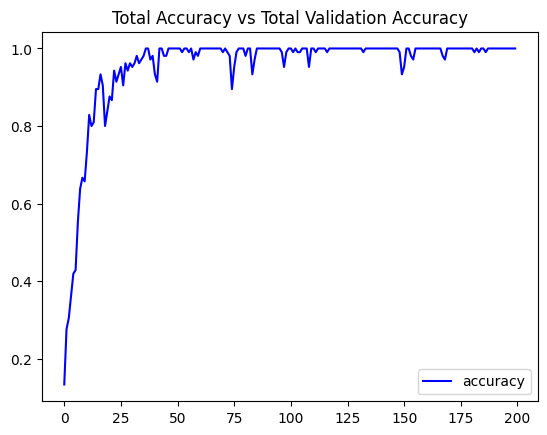

In [49]:
plot_metric(history, 'accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:


model.save('pose.h5')



In [ ]:
from tensorflow import keras
model = keras.models.load_model('pose.h5')


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 64)            50432     
                                                                 
 dropout_3 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 128)           98816     
                                                                 
 dropout_4 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [50]:
predicted_labels_probabilities = model.predict(X_test)
 


1/1 [==============================] - 4s 4s/step


In [51]:
predicted_labels_probabilities

array([[1.71779637e-15, 3.85990915e-14, 1.00000000e+00, 8.87439892e-22,
        6.68108892e-14, 4.62051543e-11],
       [4.34447374e-11, 1.76014134e-10, 1.00000000e+00, 3.17193589e-16,
        1.20640420e-09, 2.09764224e-08],
       [1.00000000e+00, 3.68977923e-19, 6.89910114e-18, 7.01832942e-21,
        4.43161782e-17, 1.05154088e-19],
       [9.45282466e-07, 7.38355506e-04, 3.40647995e-04, 1.68463809e-03,
        2.76386626e-02, 9.69596744e-01],
       [1.06917375e-24, 6.71605065e-20, 6.84611581e-26, 1.00000000e+00,
        4.34352572e-20, 8.71099633e-13],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.44495302e-33, 3.35323085e-27],
       [3.11825704e-10, 8.92432073e-10, 9.99999762e-01, 3.98093119e-14,
        7.74549207e-08, 2.11365119e-07],
       [1.30166250e-13, 1.03246545e-12, 1.00000000e+00, 1.22025555e-19,
        4.71913654e-12, 2.65203998e-10],
       [1.00000000e+00, 2.46484436e-14, 3.49255049e-13, 1.06142895e-15,
        1.21144978e-12, 

In [52]:
Y_pred = np.argmax(predicted_labels_probabilities, axis =1 )

In [53]:
Y_pred

array([2, 2, 0, 5, 3, 1, 2, 2, 0, 3, 4, 5, 2, 3, 5, 0, 1, 1, 3, 3, 0, 2,
       2, 5, 0, 5, 5], dtype=int64)

In [54]:
Y_actual = np.argmax(y_test, axis =1 )

In [55]:
Y_actual

array([2, 2, 0, 5, 3, 1, 2, 2, 0, 3, 4, 5, 2, 3, 5, 0, 1, 1, 3, 3, 0, 2,
       2, 5, 0, 5, 5], dtype=int64)

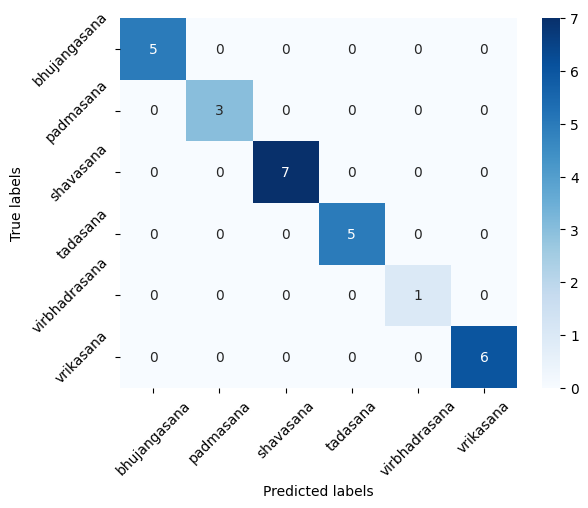

In [57]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(Y_pred, Y_actual)
ax = sns.heatmap(cm, annot=True, cmap="Blues")

# set labels
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

# set xtick labels
ax.set_xticklabels(['bhujangasana', 'padmasana', 'shavasana', 'tadasana', 'virbhadrasana', 'vrikasana'],rotation = 45)

# set ytick labels
ax.set_yticklabels(['bhujangasana', 'padmasana', 'shavasana', 'tadasana', 'virbhadrasana', 'vrikasana'],rotation = 45)

# set title
# plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [58]:
from sklearn.metrics import precision_recall_fscore_support , accuracy_score

# assume y_true and y_pred are the true and predicted labels, respectively
# y_true and y_pred should be arrays of integers, where each integer represents the class label
# with 0 representing the first class, 1 representing the second class, and so on

# calculate precision, recall, and F1 score for each class
precision, recall, f1, support = precision_recall_fscore_support(Y_pred, Y_actual)

# print the results for each class
for i in range(len(precision)):
    print("Class {}: Precision: {:.2f}, Recall: {:.2f}, F1 score: {:.2f}, Support: {}".format(CLASSES_LIST[i], precision[i], recall[i], f1[i], support[i]))

# calculate accuracy
accuracy = accuracy_score(Y_pred, Y_actual)
print("Accuracy: {:.2f}".format(accuracy))

Class bhujangasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 5
Class padmasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 3
Class shavasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 7
Class tadasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 5
Class Virbhadrasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 1
Class vrikshyasana: Precision: 1.00, Recall: 1.00, F1 score: 1.00, Support: 6
Accuracy: 1.00


In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''
    
    frames_list = frames_extraction(video_file_path)
 
    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    return predicted_class_name
        
    # Release the VideoCapture object. 
    


In [ ]:
frames_extraction('Videodata/testing_video/Bhuj/VID_20220807_093833.mp4')

In [ ]:
input_video_file_path = f'Testing/vrikasana/vri.mp4'
predicted_value = predict_single_action(input_video_file_path, SEQUENCE_LENGTH)


In [ ]:
predicted_value

In [ ]:
import cv2
import time

# Set video codec and frame rate
codec = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30.0

# Open default camera
cap = cv2.VideoCapture('http://10.187.167.250:8080/video')
if not cap.isOpened():
    print("Error opening camera.")
    exit()

# Get camera resolution and set video output size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width, height)

# Create VideoWriter object to save video
filename = "output10.mp4"
out = cv2.VideoWriter(filename, codec, fps, size)

# Record video for specified time
duration = 15.0  # in seconds
start_time = time.time()
while (time.time() - start_time) < duration:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()
predicted_value = predict_single_action(filename, SEQUENCE_LENGTH)
print(predicted_value) # Release resources


In [ ]:
datadir="Videodata/testing_video"
classlis=["Bhuj","pad","shav","tad","vrik"]
for class_index, class_name in enumerate(classlis):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(datadir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(f'file name: {file_name}')
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) 
            predicted_value = predict_single_action(video_file_path, SEQUENCE_LENGTH)
            # Get the complete video path.
            
            
            

In [ ]:
cap = cv2.VideoCapture('output10.mp4')
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image,predicted_value, (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import cv2
import time

# Set video codec and frame rate
codec = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30.0

# Open default camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error opening camera.")
    exit()

# Get camera resolution and set video output size
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
size = (width, height)

# Create VideoWriter object to save video
filename = "output3.mp4"
out = cv2.VideoWriter(filename, codec, fps, size)

# Record video for specified time
duration = 10.0  # in seconds
start_time = time.time()
while (time.time() - start_time) < duration:
    ret, frame = cap.read()
    if not ret:
        break
    out.write(frame)
    cv2.imshow("frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()




In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.fit(X_train, y_train, epochs=100,batch_size=4, callbacks=[tb_callback])